# Build Model

In [1]:
import tensorflow as tf

In [2]:
def conv(inputs, filters, filter_size=(3, 3), strides=(1, 1)):
  x = tf.keras.layers.Conv2D(filters, 
                             kernel_size=filter_size, 
                             strides=strides, 
                             padding='same', 
                             use_bias=False)(inputs)
  tf.keras.layers.BatchNormalization()(x)
  return tf.keras.layers.ReLU(6.0)(x)

def conv_dw(inputs, pw_cov_filters, strides=(1, 1)):
  # depthwise conv
  x = tf.keras.layers.DepthwiseConv2D((3, 3), 
                                      padding='same', 
                                      strides=strides,
                                      use_bias=False)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU(6.0)(x)

  # pointwise conv
  x = tf.keras.layers.Conv2D(pw_cov_filters,
                             kernel_size=(1, 1),
                             padding='same',
                             use_bias=False)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  return tf.keras.layers.ReLU(6.0)(x)

def my_mobilenet_v1(inputs, fc_neurons=64, bn=False, dp=False, dp_rate=0.5):
  x = conv(inputs, 32, strides=(2, 2))
  x = conv_dw(x, 64)
  x = conv_dw(x, 128, strides=(2, 2))
  x = conv_dw(x, 128)
  x = conv_dw(x, 256, strides=(2, 2))
  x = conv_dw(x, 256)
  x = conv_dw(x, 512, strides=(2, 2))
  x = conv_dw(x, 512)
  x = conv_dw(x, 512)
  x = conv_dw(x, 512)
  x = conv_dw(x, 512)
  x = conv_dw(x, 512)
  x = conv_dw(x, 1024, strides=(2, 2))
  x = conv_dw(x, 1024)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  if dp:
    x = tf.keras.layers.Dropout(dp_rate)(x)

  # FC layer 1
  x = tf.keras.layers.Dense(fc_neurons)(x)
  if bn:
    x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU(6.0)(x)
  if dp:
    x = tf.keras.layers.Dropout(dp_rate)(x)

  # FC layer 2
  x = tf.keras.layers.Dense(fc_neurons)(x)
  if bn:
    x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU(6.0)(x)
  if dp:
    x = tf.keras.layers.Dropout(dp_rate)(x)

  # output
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  return output

In [3]:
inputs = tf.keras.Input(shape=(224, 224, 3))
model = tf.keras.Model(inputs=inputs, outputs=my_mobilenet_v1(inputs, 64))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      864       
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 112, 112, 32)     288       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     128       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 112, 112, 32)      0     

# Build Dataset

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [5]:
# find all images
data_path = '/content/drive/MyDrive/ml_project/255_project'
df = pd.read_csv('/content/drive/MyDrive/ml_project/255_project/train.csv')
df['img_path'] = data_path + '/train/' + df.Id +'.jpg' 
df.head(1)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,img_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,/content/drive/MyDrive/ml_project/255_project/...


In [6]:
# pipeline
# image decoder
def img_decoder(path, label):
  img_file = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img_file, channels=3)
  # resize images with pad to desired size
  img = tf.image.resize_with_pad(img, img_size[0], img_size[1])
  # image normalization
  img = tf.cast(img, tf.float32) / 255.0
  # image reshape
  img = tf.reshape(img, [*img_size, 3])
  
  return img, tf.cast(label, tf.float32) / 100.0

# image augmentations
  # random flip
  # random brightness
  # random contrast
  # random hue
def img_flip(img, label):
  img = tf.image.random_flip_left_right(img)
  img = tf.reshape(img, [*img_size, 3])
  return img, label

def img_flip2(img, label):
  img = tf.image.random_flip_up_down(img)
  img = tf.reshape(img, [*img_size, 3])
  return img, label

def img_bri(img, label):
  img = tf.image.random_brightness(img, max_delta=0.2)
  img = tf.reshape(img, [*img_size, 3])
  return img, label

def img_contrast(img, label):
  img = tf.image.random_contrast(img, 0.2, 0.5)
  img = tf.reshape(img, [*img_size, 3])
  return img, label

def img_hue(img, label):
  img = tf.image.random_hue(img, max_delta=0.2)
  img = tf.reshape(img, [*img_size, 3])
  return img, label

# build dataset
def dataset_builder(path_list, labels, img_size, batch_size, augment=True):
  AUTOTUNE = tf.data.experimental.AUTOTUNE
  slices = (path_list, labels)

  ds = tf.data.Dataset.from_tensor_slices(slices)
  ds = ds.map(img_decoder, num_parallel_calls=AUTOTUNE)
  ds = ds.repeat(1)

  if augment:
    ds_flip = ds.map(img_flip, num_parallel_calls=AUTOTUNE)
    ds_filp2 = ds.map(img_flip2, num_parallel_calls=AUTOTUNE)
    ds_bri = ds.map(img_bri, num_parallel_calls=AUTOTUNE)
    ds_contrast = ds.map(img_contrast, num_parallel_calls=AUTOTUNE)
    ds_hue = ds.map(img_hue, num_parallel_calls=AUTOTUNE)
    # combine all dataset
    ds = ds.concatenate(ds_flip).concatenate(ds_filp2).concatenate(ds_bri).concatenate(ds_contrast).concatenate(ds_hue)

  ds = ds.shuffle(10 * batch_size)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(AUTOTUNE)
  return ds

In [7]:
paths = df.img_path.tolist()
labels = df.Pawpularity.tolist()
X_train, X_test, y_train, y_test = train_test_split(paths, labels, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=40)

In [26]:
img_size = [224, 224]
batch_size = 128

ds_train = dataset_builder(X_train, y_train, img_size=img_size, batch_size=batch_size)
ds_val = dataset_builder(X_val, y_val, img_size=img_size, batch_size=batch_size, augment=False)
ds_test = dataset_builder(X_test, y_test, img_size=img_size, batch_size=batch_size, augment=False)
print('train set size:', len(ds_train) * batch_size)
print('val set size:', len(ds_val) * batch_size)
print('test set size:', len(ds_test) * batch_size)

train set size: 38144
val set size: 1664
test set size: 2048


# Model Train

Try different batch_size: 32, 64, 128

In [22]:
batch_size = [32, 64, 128]
img_size = [224, 224]
epochs = 5

for batch in batch_size:
  inputs = tf.keras.Input(shape=(img_size[0], img_size[1], 3))
  model = tf.keras.Model(inputs=inputs, outputs=my_mobilenet_v1(inputs))

  ds_train = dataset_builder(X_train, y_train, img_size=img_size, batch_size=batch)
  ds_val = dataset_builder(X_val, y_val, img_size=img_size, batch_size=batch, augment=False)
  print('----------------------------------------')
  print('Train model with batch size of: ', batch)

  # learning rate scheduling
  init_lr = 1e-2
  decay_steps = epochs
  alpha = 1e-2

  lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      init_lr, decay_steps, alpha)
      
  opt = tf.optimizers.Adam(lr_decayed_fn)

  loss = tf.keras.losses.MeanSquaredError()

  model.compile(loss=loss,
                optimizer=opt, 
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(ds_train, 
                    epochs=epochs,
                    validation_data=ds_val,
                    callbacks=tf.keras.callbacks.EarlyStopping('val_loss', 
                                                               patience=3,
                                                               restore_best_weights=True))
  print('Model train with batch size of', batch, 'is complete')
  print('----------------------------------------')

----------------------------------------
Train model with batch size of:  32
Epoch 1/5
1190/1190 [==============================] - 288s 210ms/step - loss: 0.0441 - root_mean_squared_error: 0.2099 - val_loss: 0.0416 - val_root_mean_squared_error: 0.2040
Epoch 2/5
1190/1190 [==============================] - 260s 217ms/step - loss: 0.0413 - root_mean_squared_error: 0.2033 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2053
Epoch 3/5
1190/1190 [==============================] - 262s 219ms/step - loss: 0.0394 - root_mean_squared_error: 0.1984 - val_loss: 0.0451 - val_root_mean_squared_error: 0.2123
Epoch 4/5
1190/1190 [==============================] - 263s 220ms/step - loss: 0.0353 - root_mean_squared_error: 0.1880 - val_loss: 0.0497 - val_root_mean_squared_error: 0.2230
Model train with batch size of 32 is complete
----------------------------------------
----------------------------------------
Train model with batch size of:  64
Epoch 1/5
595/595 [==============================] 


Conclusion: best batch size is 128

---

image size other than 224 eats too much ram

---



try different numbers of FC neurons: 128, 256, 512, 1024

In [24]:
batch_size = 128
img_size = [224, 224]
num_neurons = [128, 256, 512, 1024]
epochs = 5

for neuron in num_neurons:
  inputs = tf.keras.Input(shape=(img_size[0], img_size[1], 3))
  model = tf.keras.Model(inputs=inputs, outputs=my_mobilenet_v1(inputs, 
                                                                fc_neurons=neuron,
                                                                dp=True))

  ds_train = dataset_builder(X_train, y_train, img_size=img_size, batch_size=batch_size)
  ds_val = dataset_builder(X_val, y_val, img_size=img_size, batch_size=batch_size, augment=False)
  print('----------------------------------------')
  print('Train model with number of FC neurons: ', neuron)

  # learning rate scheduling
  init_lr = 1e-2
  decay_steps = epochs
  alpha = 1e-2

  lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      init_lr, decay_steps, alpha)
      
  opt = tf.optimizers.Adam(lr_decayed_fn)

  loss = tf.keras.losses.MeanSquaredError()

  model.compile(loss=loss,
                optimizer=opt, 
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(ds_train, 
                    epochs=epochs,
                    validation_data=ds_val,
                    callbacks=tf.keras.callbacks.EarlyStopping('val_loss', 
                                                               patience=3,
                                                               restore_best_weights=True))
  print('Model train with number of FC neurons:', neuron, 'is complete')
  print('----------------------------------------')

----------------------------------------
Train model with number of FC neurons:  128
Epoch 1/5
298/298 [==============================] - 254s 823ms/step - loss: 0.0985 - root_mean_squared_error: 0.3138 - val_loss: 0.0457 - val_root_mean_squared_error: 0.2137
Epoch 2/5
298/298 [==============================] - 252s 825ms/step - loss: 0.0504 - root_mean_squared_error: 0.2244 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2046
Epoch 3/5
298/298 [==============================] - 254s 831ms/step - loss: 0.0481 - root_mean_squared_error: 0.2194 - val_loss: 0.0443 - val_root_mean_squared_error: 0.2104
Epoch 4/5
298/298 [==============================] - 256s 836ms/step - loss: 0.0462 - root_mean_squared_error: 0.2150 - val_loss: 0.0442 - val_root_mean_squared_error: 0.2103
Epoch 5/5
298/298 [==============================] - 253s 828ms/step - loss: 0.0449 - root_mean_squared_error: 0.2118 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2051
Model train with number of FC neurons: 1

KeyboardInterrupt: ignored

Conclusion: number of neurons higher than 256 shows poor performance.

---

Try Batch Normalization

In [ ]:
# batch_size = 128
# img_size = [224, 224]
# num_neurons = 512
# bn = True
# epochs = 10

# inputs = tf.keras.Input(shape=(img_size[0], img_size[1], 3))
# model = tf.keras.Model(inputs=inputs, outputs=my_mobilenet_v1(inputs, 
#                                                               num_neurons, 
#                                                               bn=bn))
# print('----------------------------------------')
# print('Train model with bn')

# # learning rate scheduling
# init_lr = 1e-2
# decay_steps = epochs
# alpha = 1e-2

# lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
#     init_lr, decay_steps, alpha)
    
# opt = tf.optimizers.Adam(lr_decayed_fn)

# loss = tf.keras.losses.MeanSquaredError()

# model.compile(loss=loss,
#               optimizer=opt, 
#               metrics=[tf.keras.metrics.RootMeanSquaredError()])

# history = model.fit(ds_train, 
#                   epochs=epochs,
#                   validation_data=ds_val,
#                   callbacks=tf.keras.callbacks.EarlyStopping('val_loss', 
#                                                               patience=3,
#                                                               restore_best_weights=True))
# print('Model train with bn is complete')
# print('----------------------------------------')

----------------------------------------
Train model with bn
Epoch 1/5
298/298 [==============================] - 264s 851ms/step - loss: 0.7714 - root_mean_squared_error: 0.2526 - val_loss: 0.6650 - val_root_mean_squared_error: 0.2041
Epoch 2/5
298/298 [==============================] - 259s 847ms/step - loss: 0.6637 - root_mean_squared_error: 0.2040 - val_loss: 0.6911 - val_root_mean_squared_error: 0.2344
Epoch 3/5
298/298 [==============================] - 259s 846ms/step - loss: 0.6597 - root_mean_squared_error: 0.1991 - val_loss: 0.6685 - val_root_mean_squared_error: 0.2082
Epoch 4/5
298/298 [==============================] - 257s 841ms/step - loss: 0.6538 - root_mean_squared_error: 0.1919 - val_loss: 0.6806 - val_root_mean_squared_error: 0.2164
Model train with bn is complete
----------------------------------------


Conclusion: bn for last 2 fc layers does not show better performance

---

In [27]:
import matplotlib.pyplot as plt
def plot_rmse_loss(history):
  fig, axs = plt.subplots(1,2,figsize=(15,5)) 

  # validation acc and train acc
  axs[0].plot(history.history['root_mean_squared_error']) 
  axs[0].plot(history.history['val_root_mean_squared_error']) 
  axs[0].set_title('Validation & Train RMSE')
  axs[0].set_ylabel('RMSE') 
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train', 'validation'], loc='upper left')

  # validation loss and train loss
  axs[1].plot(history.history['loss']) 
  axs[1].plot(history.history['val_loss']) 
  axs[1].set_title('Validation & Train Loss')
  axs[1].set_ylabel('Loss') 
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train', 'validation'], loc='upper right')

  plt.show()

Train the whole network

Then freeze the mobilenet 

apply dropout to fc layers with dp_rate = 0.5

In [17]:
def freeze_layers(model):
  for layer in model.layers[:-9]:
    layer.trainable = False

  # learning rate scheduling
  init_lr = 1e-2
  decay_steps = 20
  alpha = 1e-2

  lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      init_lr, decay_steps, alpha)
      
  opt = tf.optimizers.Adam(lr_decayed_fn)

  loss = tf.keras.losses.MeanSquaredError()

  model.compile(loss=loss,
                optimizer=opt, 
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [32]:
batch_size = 128
img_size = [224, 224]
num_neurons = 256
bn = False
dp = True
dp_rate = 0.5
epochs = 10

inputs = tf.keras.Input(shape=(img_size[0], img_size[1], 3))
model = tf.keras.Model(inputs=inputs, outputs=my_mobilenet_v1(inputs, 
                                                              fc_neurons=256,
                                                              dp=True))

print('----------------------------------------')
print('Train model with mobilenet')

# learning rate scheduling
init_lr = 1e-2
decay_steps = epochs
alpha = 1e-2

lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    init_lr, decay_steps, alpha)
    
opt = tf.optimizers.Adam(lr_decayed_fn)

loss = tf.keras.losses.MeanSquaredError()

model.compile(loss=loss,
              optimizer=opt, 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(ds_train, 
                  epochs=epochs,
                  validation_data=ds_val,
                  callbacks=tf.keras.callbacks.EarlyStopping('val_loss', 
                                                               patience=3,
                                                               restore_best_weights=True))
print('Model train completed')
print('----------------------------------------')

----------------------------------------
Train model with mobilenet
Epoch 1/10
298/298 [==============================] - 250s 807ms/step - loss: 0.0839 - root_mean_squared_error: 0.2897 - val_loss: 0.0522 - val_root_mean_squared_error: 0.2285
Epoch 2/10
298/298 [==============================] - 247s 809ms/step - loss: 0.0507 - root_mean_squared_error: 0.2252 - val_loss: 0.0416 - val_root_mean_squared_error: 0.2041
Epoch 3/10
298/298 [==============================] - 248s 814ms/step - loss: 0.0471 - root_mean_squared_error: 0.2169 - val_loss: 0.0503 - val_root_mean_squared_error: 0.2243
Epoch 4/10
298/298 [==============================] - 248s 813ms/step - loss: 0.0458 - root_mean_squared_error: 0.2140 - val_loss: 0.0424 - val_root_mean_squared_error: 0.2059
Epoch 5/10
298/298 [==============================] - 243s 796ms/step - loss: 0.0436 - root_mean_squared_error: 0.2088 - val_loss: 0.0426 - val_root_mean_squared_error: 0.2065
Model train completed
------------------------------

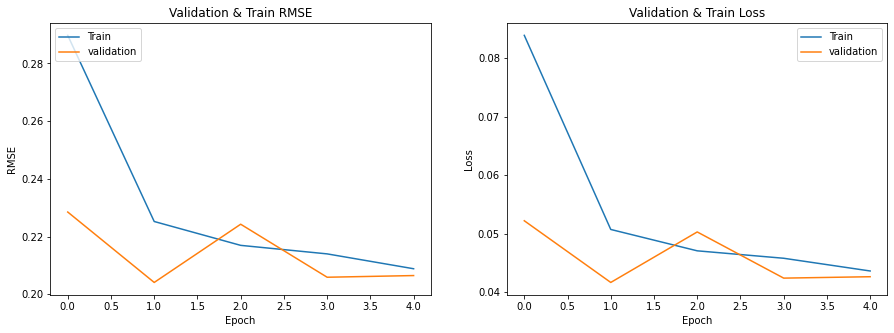

In [33]:
plot_rmse_loss(history)

Freeze mobilenet

In [34]:
freeze_layers(model)
history = model.fit(ds_train, 
                  epochs=epochs,
                  validation_data=ds_val,
                  callbacks=tf.keras.callbacks.EarlyStopping('val_loss', 
                                                              patience=3,
                                                              restore_best_weights=True))

Epoch 1/10
298/298 [==============================] - 196s 633ms/step - loss: 0.0433 - root_mean_squared_error: 0.2081 - val_loss: 0.0428 - val_root_mean_squared_error: 0.2069
Epoch 2/10
298/298 [==============================] - 194s 632ms/step - loss: 0.0428 - root_mean_squared_error: 0.2070 - val_loss: 0.0430 - val_root_mean_squared_error: 0.2073
Epoch 3/10
298/298 [==============================] - 199s 648ms/step - loss: 0.0428 - root_mean_squared_error: 0.2068 - val_loss: 0.0432 - val_root_mean_squared_error: 0.2078
Epoch 4/10
298/298 [==============================] - 202s 657ms/step - loss: 0.0426 - root_mean_squared_error: 0.2065 - val_loss: 0.0431 - val_root_mean_squared_error: 0.2076


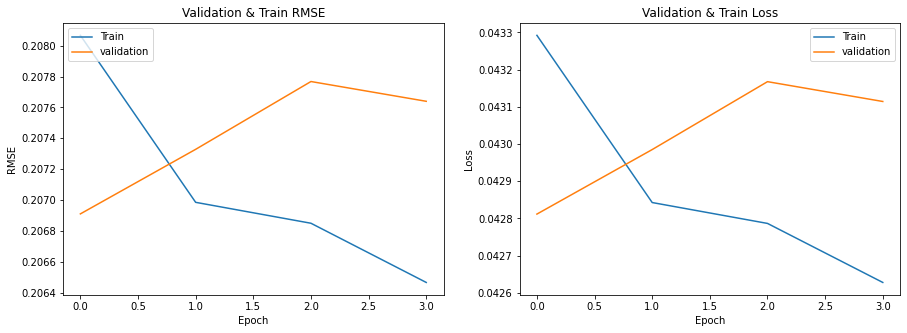

In [35]:
plot_rmse_loss(history)

In [36]:
loss, rmse = model.evaluate(ds_test)
print('Test set RMSE is:', rmse)

16/16 [==============================] - 254s 5s/step - loss: 0.0459 - root_mean_squared_error: 0.2142
Test set RMSE is: 0.21420536935329437


Try TensorFlow MobileNetV2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
batch_size = 128
img_size = [224, 224]

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(img_size[0], img_size[1], 3), 
    include_top=False)
# freeze mobilenet layers
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# learning rate scheduling
init_lr = 1e-2
decay_steps = 20
alpha = 1e-2

lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    init_lr, decay_steps, alpha)
    
opt = tf.optimizers.Adam(lr_decayed_fn)

loss = tf.keras.losses.MeanSquaredError()

model.compile(loss=loss, optimizer=opt, 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_24  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_30 (Dropout)        (None, 1280)              0         
                                                                 
 dense_72 (Dense)            (None, 512)               655872    
                                                                 
 dropout_31 (Dropout)        (None, 512)               0         
                                                                 
 dense_73 (Dense)            (None, 512)              

In [ ]:
history = model.fit(ds_train, 
                    epochs=20, 
                    steps_per_epoch=len(ds_train), 
                    validation_data=ds_val,
                    callbacks=tf.keras.callbacks.EarlyStopping('val_loss', 
                                                               patience=3,
                                                               restore_best_weights=True))

Epoch 1/20
298/298 [==============================] - 211s 677ms/step - loss: 0.7822 - root_mean_squared_error: 0.2205 - val_loss: 0.6652 - val_root_mean_squared_error: 0.2046
Epoch 2/20
298/298 [==============================] - 205s 668ms/step - loss: 0.6654 - root_mean_squared_error: 0.2059 - val_loss: 0.6645 - val_root_mean_squared_error: 0.2038
Epoch 3/20
298/298 [==============================] - 204s 664ms/step - loss: 0.6628 - root_mean_squared_error: 0.2028 - val_loss: 0.6646 - val_root_mean_squared_error: 0.2040
Epoch 4/20
298/298 [==============================] - 205s 669ms/step - loss: 0.6617 - root_mean_squared_error: 0.2015 - val_loss: 0.6641 - val_root_mean_squared_error: 0.2034
Epoch 5/20
298/298 [==============================] - 203s 661ms/step - loss: 0.6604 - root_mean_squared_error: 0.1999 - val_loss: 0.6635 - val_root_mean_squared_error: 0.2026
Epoch 6/20
298/298 [==============================] - 204s 665ms/step - loss: 0.6594 - root_mean_squared_error: 0.1987 -

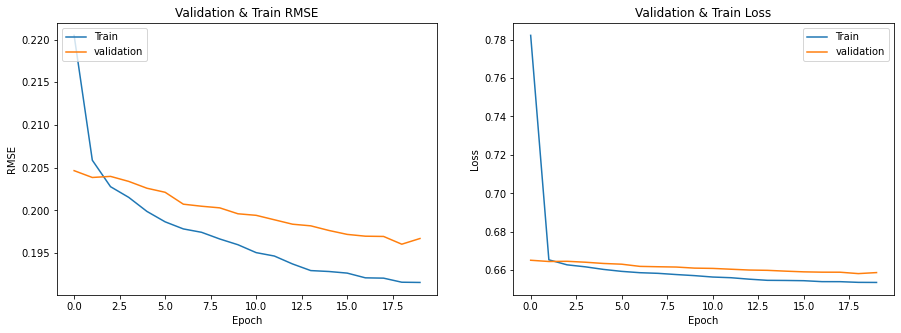

In [ ]:
plot_rmse_loss(history)

In [ ]:
# save model
model.save('/content/drive/MyDrive/ml_project/255_project/mobilev2_512fc_freeze.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Unfreeze layers

In [ ]:
def unfreeze_layers(model):
  for layer in model.layers:
    layer.trainable = True

  # learning rate scheduling
  opt = tf.optimizers.Adam(learning_rate=1e-4)
  loss = tf.keras.losses.MeanSquaredError()

  model.compile(loss=loss,
                optimizer=opt, 
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
unfreeze_layers(model)
history = model.fit(ds_train, 
                    epochs=20, 
                    steps_per_epoch=len(ds_train), 
                    validation_data=ds_val,
                    callbacks=tf.keras.callbacks.EarlyStopping('val_loss', 
                                                               patience=3,
                                                               restore_best_weights=True))

Epoch 1/20
298/298 [==============================] - 259s 836ms/step - loss: 0.6892 - root_mean_squared_error: 0.2163 - val_loss: 0.6641 - val_root_mean_squared_error: 0.2032
Epoch 2/20
298/298 [==============================] - 256s 837ms/step - loss: 0.6713 - root_mean_squared_error: 0.2104 - val_loss: 0.6643 - val_root_mean_squared_error: 0.2034
Epoch 3/20
298/298 [==============================] - 255s 836ms/step - loss: 0.6671 - root_mean_squared_error: 0.2073 - val_loss: 0.6639 - val_root_mean_squared_error: 0.2030
Epoch 4/20
298/298 [==============================] - 252s 826ms/step - loss: 0.6651 - root_mean_squared_error: 0.2056 - val_loss: 0.6639 - val_root_mean_squared_error: 0.2030
Epoch 5/20
298/298 [==============================] - 252s 825ms/step - loss: 0.6647 - root_mean_squared_error: 0.2052 - val_loss: 0.6641 - val_root_mean_squared_error: 0.2032
Epoch 6/20
298/298 [==============================] - 255s 834ms/step - loss: 0.6640 - root_mean_squared_error: 0.2045 -

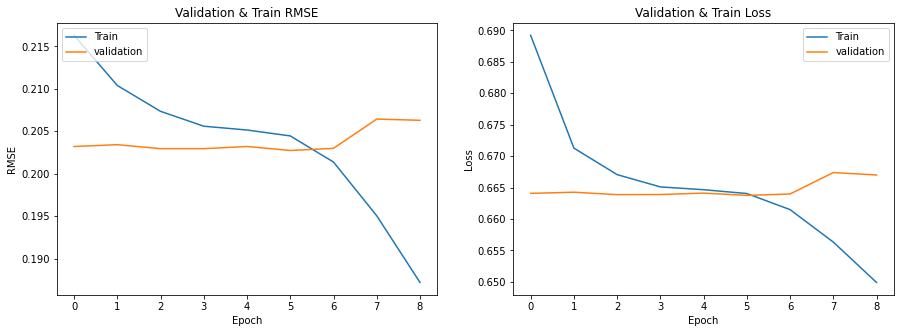

In [ ]:
plot_rmse_loss(history)

Model test

In [ ]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/ml_project/255_project/mobilev2_512fc_freeze.h5')
best_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_24  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_30 (Dropout)        (None, 1280)              0         
                                                                 
 dense_72 (Dense)            (None, 512)               655872    
                                                                 
 dropout_31 (Dropout)        (None, 512)               0         
                                                                 
 dense_73 (Dense)            (None, 512)              

In [ ]:
loss, rmse = best_model.evaluate(ds_test)
print('Test set RMSE is:', rmse)

16/16 [==============================] - 98s 6s/step - loss: 0.6606 - root_mean_squared_error: 0.2039
Test set RMSE is: 0.2039112150669098
